In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datasets import load_from_disk
from PIL import Image
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple

from mrl_loader import MRLLoader
from linear_metrics import LinearMetricsCalculator, compute_linear_metrics

In [32]:
model_path = "/home/mmkuznecov/SkolCourses/DL/FINAL_PROJECT/MRL/train/logs/98819cd7-62aa-479e-8642-f4333540615e/final_weights.pt" 
model = MRLLoader(model_path)

Initializing resnet50 model...


/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying BlurPool...
Loading weights from /home/mmkuznecov/SkolCourses/DL/FINAL_PROJECT/MRL/train/logs/98819cd7-62aa-479e-8642-f4333540615e/final_weights.pt...
Model weights loaded successfully!
Model loaded on cuda
Available embedding dimensions: [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
Output embedding dimension set to 8


/home/mmkuznecov/SkolCourses/DL/FINAL_PROJECT/MRL/mrl_loader.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.weights_path, map_location='c

In [33]:
model

In [34]:
model.set_output_emb_dim(8)

Output embedding dimension set to 8


In [35]:
random_input = torch.randn(4, 3, 224, 224)
predictions_8, embeddings_8 = model.predict_with_embeddings(random_input)
predictions_8.shape, embeddings_8.shape

(torch.Size([4, 1000]), torch.Size([4, 8]))

In [36]:
model.set_output_emb_dim(16)

Output embedding dimension set to 16


In [37]:
predictions_16, embeddings_16 = model.predict_with_embeddings(random_input)
predictions_16.shape, embeddings_16.shape

(torch.Size([4, 1000]), torch.Size([4, 16]))

In [38]:
embeddings_8 == embeddings_16[:, :8]

tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]], device='cuda:0')

In [39]:
dataset_path = "data/imagenet_1k_resized_256_test"
ds = load_from_disk(dataset_path)
print(f"Loaded dataset with {len(ds)} samples")

Loaded dataset with 100000 samples


In [40]:
sample = ds[0]
print(f"Sample image shape: {sample['image'].size}, Label: {sample['label']}")

Sample image shape: (373, 256), Label: -1


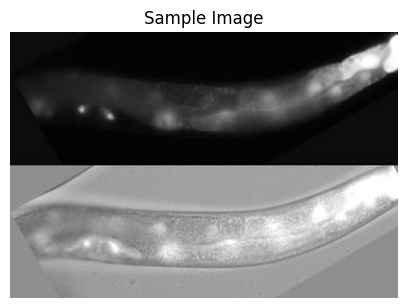

In [41]:
plt.figure(figsize=(5, 5))
plt.imshow(sample['image'])
plt.axis('off')
plt.title("Sample Image")
plt.show()

In [42]:
def extract_all_embeddings_simultaneously(model: MRLLoader,
                                    dataset,
                                    batch_size: int = 32,
                                    num_samples: int = None,
                                    random_seed: int = 42) -> Dict[int, np.ndarray]:
    """
    Extract embeddings for ALL dimensions simultaneously from the model for images in the dataset.
    This is much more efficient than extracting embeddings for each dimension separately.
    
    Args:
        model: MRLLoader model
        dataset: HuggingFace dataset
        batch_size: Batch size for processing
        num_samples: Number of samples to process (None = all)
        random_seed: Random seed for sampling
        
    Returns:
        Dictionary mapping each dimension to its embeddings array with shape (num_samples, dim)
        and a numpy array of labels
    """
    # Determine number of samples to process
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # If we're not using all samples, randomly select indices
    if num_samples < len(dataset):
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    else:
        indices = range(num_samples)
    
    # Get available dimensions
    available_dims = model.get_available_dimensions()
    
    # Initialize dictionaries to store embeddings for each dimension
    all_embeddings_dict = {dim: [] for dim in available_dims}
    all_labels = []
    
    # Process in batches
    for i in tqdm(range(0, len(indices), batch_size), desc=f"Extracting embeddings for all dimensions"):
        batch_indices = indices[i:i+batch_size]
        batch_images = []
        batch_labels = []
        
        # Process each image in the batch
        for idx in batch_indices:
            sample = dataset[idx]
            image = sample['image']
            label = sample['label']
            
            batch_images.append(image)
            batch_labels.append(label)
        
        # Get embeddings for ALL dimensions in a single forward pass
        with torch.no_grad():
            # Use the new forward_all_dimensions method
            batch_embeddings_dict = model.forward_all_dimensions(batch_images)
            
            # Add embeddings for each dimension to their respective lists
            for dim, embeddings in batch_embeddings_dict.items():
                all_embeddings_dict[dim].append(embeddings.cpu().numpy())
            
            all_labels.extend(batch_labels)
    
    # Concatenate all batches for each dimension
    result_dict = {}
    for dim, embeddings_list in all_embeddings_dict.items():
        result_dict[dim] = np.vstack(embeddings_list)
    
    labels_array = np.array(all_labels)
    
    # Print summary
    for dim, embeddings in result_dict.items():
        print(f"Extracted {embeddings.shape[0]} embeddings with dimension {dim}")
    
    return result_dict, labels_array

In [43]:
num_samples = len(ds)

In [44]:
print("Extracting embeddings for all dimensions simultaneously...")
embeddings_dict, labels = extract_all_embeddings_simultaneously(
    model=model,
    dataset=ds,
    batch_size=64,
    num_samples=num_samples
)

Extracting embeddings for all dimensions simultaneously...


Extracting embeddings for all dimensions: 100%|██████████| 1563/1563 [05:17<00:00,  4.92it/s]


Extracted 100000 embeddings with dimension 8
Extracted 100000 embeddings with dimension 16
Extracted 100000 embeddings with dimension 32
Extracted 100000 embeddings with dimension 64
Extracted 100000 embeddings with dimension 128
Extracted 100000 embeddings with dimension 256
Extracted 100000 embeddings with dimension 512
Extracted 100000 embeddings with dimension 1024
Extracted 100000 embeddings with dimension 2048


In [45]:
embedding_dims = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
filtered_embeddings_dict = {dim: embeddings_dict[dim] for dim in embedding_dims if dim in embeddings_dict}

In [46]:
mrl_embeddings = filtered_embeddings_dict[2048]

In [47]:
pca = PCA().fit(mrl_embeddings)
mrl_evr = pca.explained_variance_ratio_

In [48]:
def compute_normalized_derivatives(evr):
    # Normalize EVR to sum to 1 (just in case it's not already)
    evr = evr / np.sum(evr)
    v = np.diff(evr)
    a = np.diff(evr, n=2)
    return evr, v, a

def plot_evr_and_derivatives(evr, title, save_path=None):
    evr_norm, v, a = compute_normalized_derivatives(evr)
    x = np.arange(len(evr_norm))
    
    plt.figure(figsize=(15, 10))
    
    # Plot normalized EVR
    plt.subplot(3, 1, 1)
    plt.plot(x, evr_norm, marker='o', markersize=3)
    plt.title(f"{title}: Normalized Explained Variance Ratio")
    plt.xlabel("Component Index")
    plt.ylabel("Normalized EVR")
    plt.grid(True)
    
    # Plot first derivative (velocity)
    plt.subplot(3, 1, 2)
    plt.plot(x[1:], v, marker='x', markersize=3, color='orange')
    plt.title("First Derivative (Velocity)")
    plt.xlabel("Component Index")
    plt.ylabel("First Derivative")
    plt.grid(True)
    
    # Plot second derivative (acceleration)
    plt.subplot(3, 1, 3)
    plt.plot(x[2:], a, marker='s', markersize=3, color='green')
    plt.title("Second Derivative (Acceleration)")
    plt.xlabel("Component Index")
    plt.ylabel("Second Derivative")
    plt.grid(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

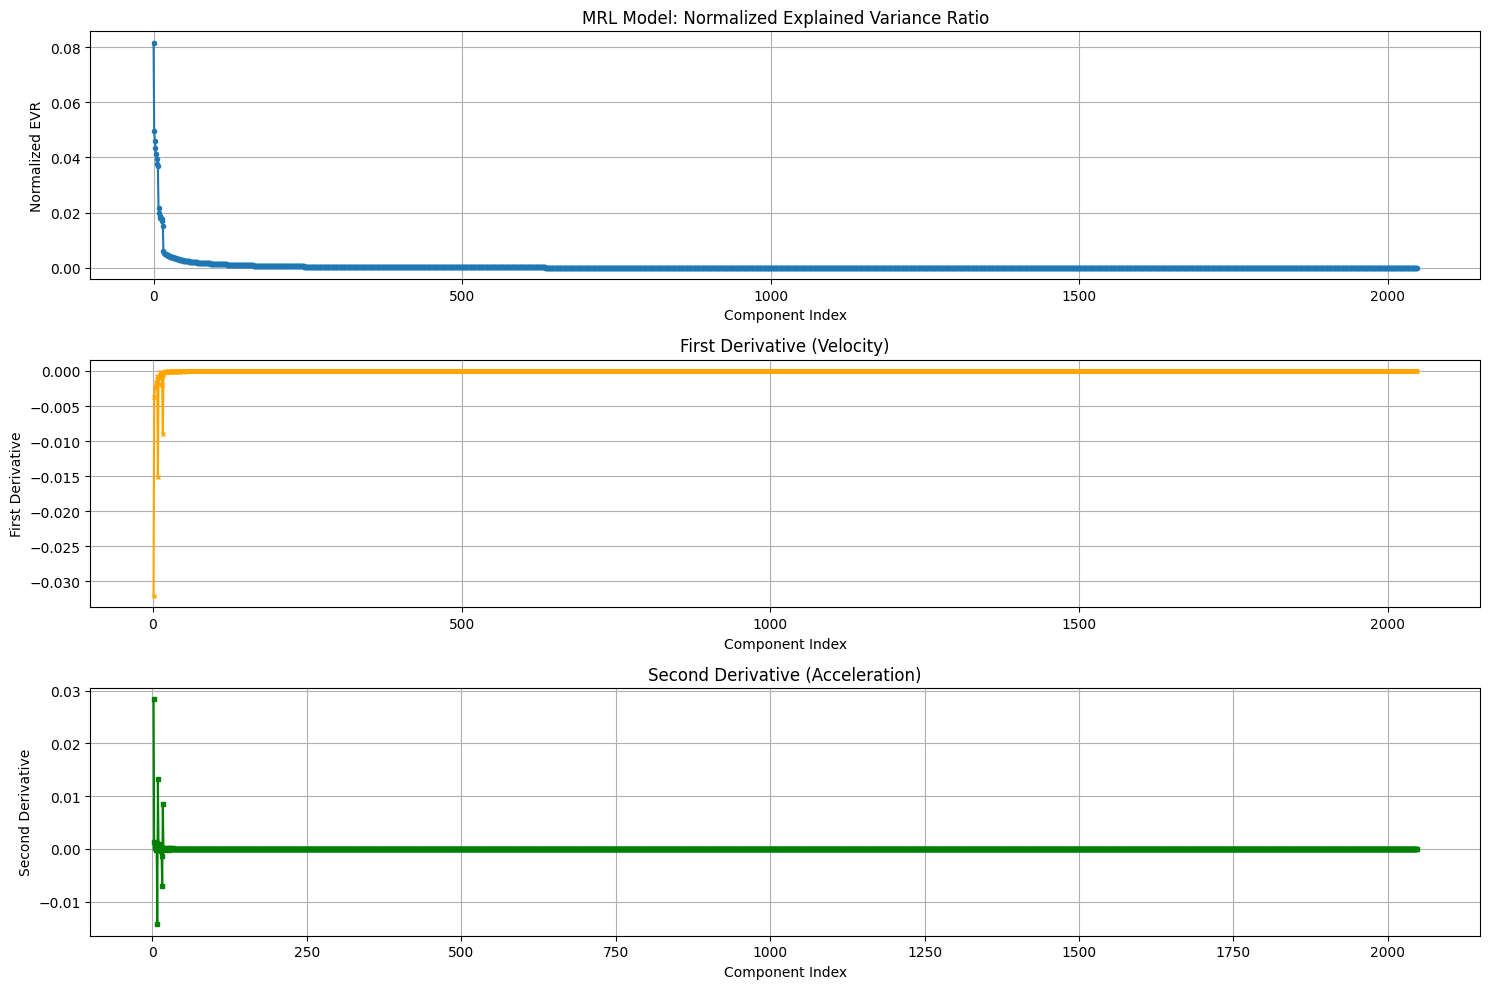

In [49]:
plot_evr_and_derivatives(mrl_evr, "MRL Model", save_path="reports/mrl_evr_derivatives.png")

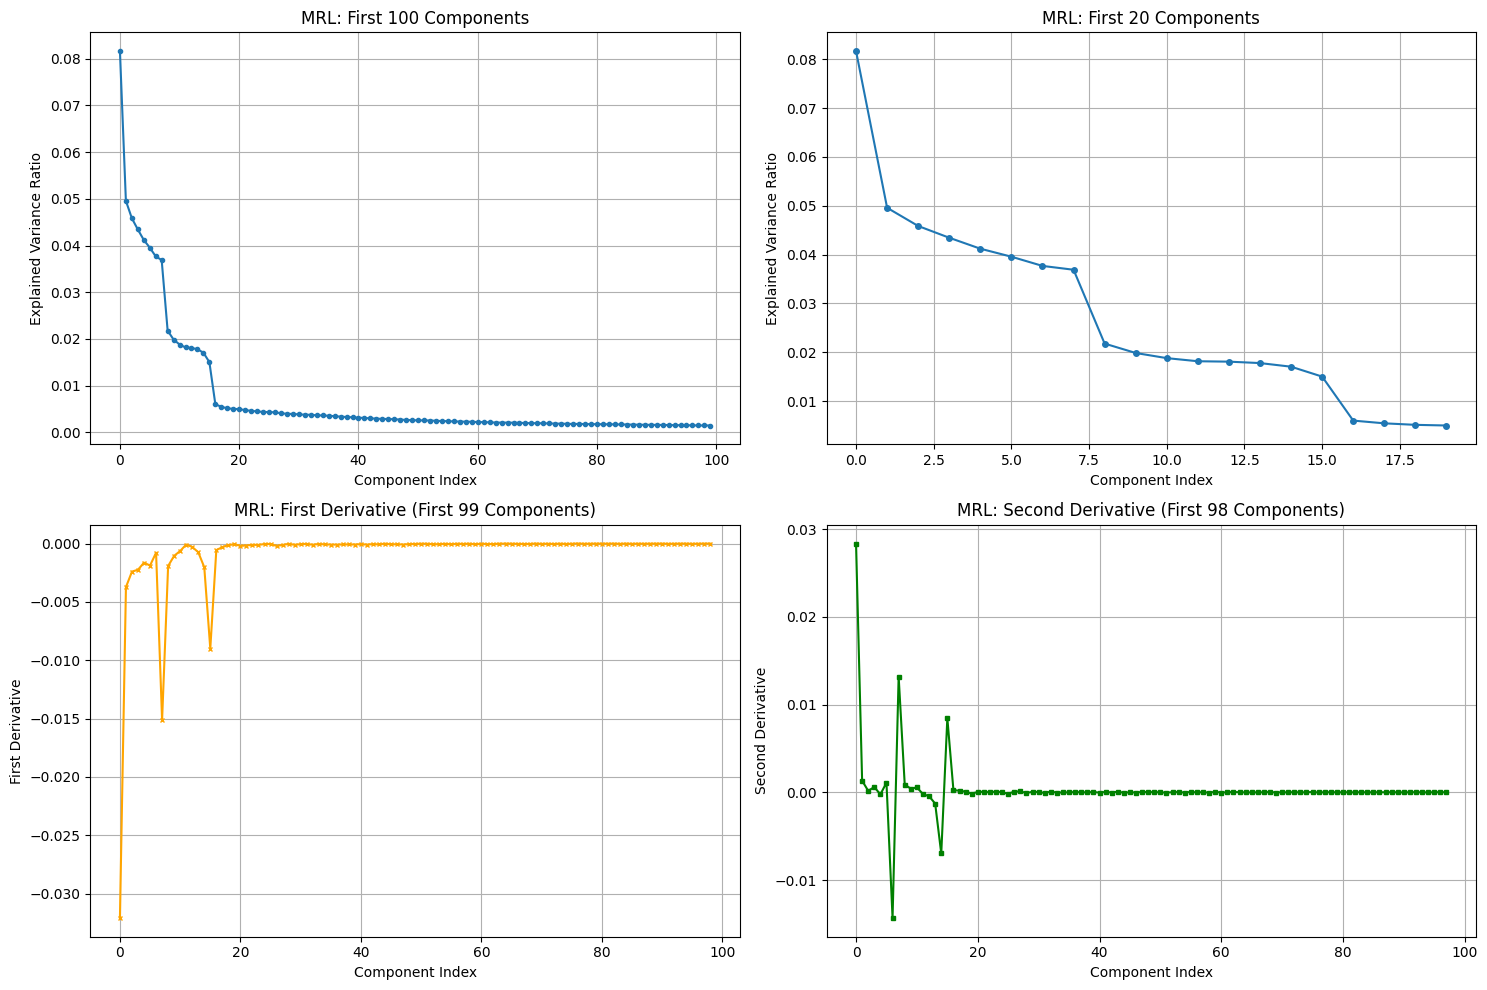

In [50]:
plt.figure(figsize=(15, 10))

# Plot first 100 components
plt.subplot(2, 2, 1)
plt.plot(mrl_evr[:100], marker='o', markersize=3)
plt.title("MRL: First 100 Components")
plt.xlabel("Component Index")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)

# Plot first 20 components
plt.subplot(2, 2, 2)
plt.plot(mrl_evr[:20], marker='o', markersize=4)
plt.title("MRL: First 20 Components")
plt.xlabel("Component Index")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)

# Plot derivatives for first 100 components
_, v_mrl, a_mrl = compute_normalized_derivatives(mrl_evr)
plt.subplot(2, 2, 3)
plt.plot(v_mrl[:99], marker='x', markersize=3, color='orange')
plt.title("MRL: First Derivative (First 99 Components)")
plt.xlabel("Component Index")
plt.ylabel("First Derivative")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(a_mrl[:98], marker='s', markersize=3, color='green')
plt.title("MRL: Second Derivative (First 98 Components)")
plt.xlabel("Component Index")
plt.ylabel("Second Derivative")
plt.grid(True)

plt.tight_layout()
plt.savefig("reports/mrl_evr_detailed.png")
plt.show()

In [14]:
metrics_calculator = LinearMetricsCalculator()

# Dictionary to store metrics for each dimension
metrics_results = {}

# Calculate metrics for each embedding dimension
for dim, embeddings in filtered_embeddings_dict.items():
    print(f"Computing metrics for {dim}d embeddings...")
    metrics = metrics_calculator.compute_metrics(embeddings, cache_key=f"dim_{dim}")
    metrics_results[dim] = metrics
    
    # Print key metrics
    print(f"  Effective Rank: {metrics['effective_rank']:.2f}")
    print(f"  Condition Number: {metrics['condition_number']:.2f}")
    print(f"  Explained Variance (top 10): {metrics['explained_variance_top10']:.4f}")
    print(f"  Average Correlation: {metrics['avg_correlation']:.4f}")
    print()

Computing metrics for 8d embeddings...
  Effective Rank: 6.55
  Condition Number: 4.52
  Explained Variance (top 10): 1.0000
  Average Correlation: 0.1495

Computing metrics for 16d embeddings...
  Effective Rank: 11.88
  Condition Number: 7.86
  Explained Variance (top 10): 0.9410
  Average Correlation: 0.0946

Computing metrics for 32d embeddings...
  Effective Rank: 21.84
  Condition Number: 16.80
  Explained Variance (top 10): 0.8957
  Average Correlation: 0.1190

Computing metrics for 64d embeddings...


/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  Effective Rank: 41.02
  Condition Number: 30.38
  Explained Variance (top 10): 0.8667
  Average Correlation: 0.1441

Computing metrics for 128d embeddings...
  Effective Rank: 79.91
  Condition Number: 66.76
  Explained Variance (top 10): 0.8510
  Average Correlation: 0.0925

Computing metrics for 256d embeddings...
  Effective Rank: 159.62
  Condition Number: 87.18
  Explained Variance (top 10): 0.7851
  Average Correlation: 0.0707

Computing metrics for 512d embeddings...
  Effective Rank: 303.05
  Condition Number: 152.56
  Explained Variance (top 10): 0.7360
  Average Correlation: 0.0581

Computing metrics for 1024d embeddings...
  Effective Rank: 572.67
  Condition Number: 416.07
  Explained Variance (top 10): 0.6938
  Average Correlation: 0.0507

Computing metrics for 2048d embeddings...
  Effective Rank: 1105.78
  Condition Number: 487.22
  Explained Variance (top 10): 0.6450
  Average Correlation: 0.0435



## Regular pretrained ImageNet Resnet50

Using device: cuda
Loaded dataset with 50000 samples
Loading pretrained ResNet50...


/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmkuznecov/miniconda3/envs/ffcv_mri/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Creating feature extractor...

Evaluating full ResNet50 model...


Evaluating full model: 100%|██████████| 1563/1563 [02:45<00:00,  9.42it/s]


Full ResNet50 - Top-1 Accuracy: 0.7371, Top-5 Accuracy: 0.9160

Extracting embeddings from the validation set...


Extracting embeddings: 100%|██████████| 1563/1563 [02:41<00:00,  9.65it/s]


Extracted 50000 embeddings with shape (50000, 2048)

Evaluating with 8 SVD components...
Applying SVD to reduce from 2048 to 8 dimensions...
Computing logits and accuracy...
SVD 8 - Explained Variance: 0.1808, Top-1 Accuracy: 0.0271, Top-5 Accuracy: 0.1155

Evaluating with 16 SVD components...
Applying SVD to reduce from 2048 to 16 dimensions...
Computing logits and accuracy...
SVD 16 - Explained Variance: 0.2781, Top-1 Accuracy: 0.1049, Top-5 Accuracy: 0.3232

Evaluating with 32 SVD components...
Applying SVD to reduce from 2048 to 32 dimensions...
Computing logits and accuracy...
SVD 32 - Explained Variance: 0.4056, Top-1 Accuracy: 0.2962, Top-5 Accuracy: 0.6520

Evaluating with 64 SVD components...
Applying SVD to reduce from 2048 to 64 dimensions...
Computing logits and accuracy...
SVD 64 - Explained Variance: 0.5686, Top-1 Accuracy: 0.5495, Top-5 Accuracy: 0.8366

Evaluating with 128 SVD components...
Applying SVD to reduce from 2048 to 128 dimensions...
Computing logits and accur

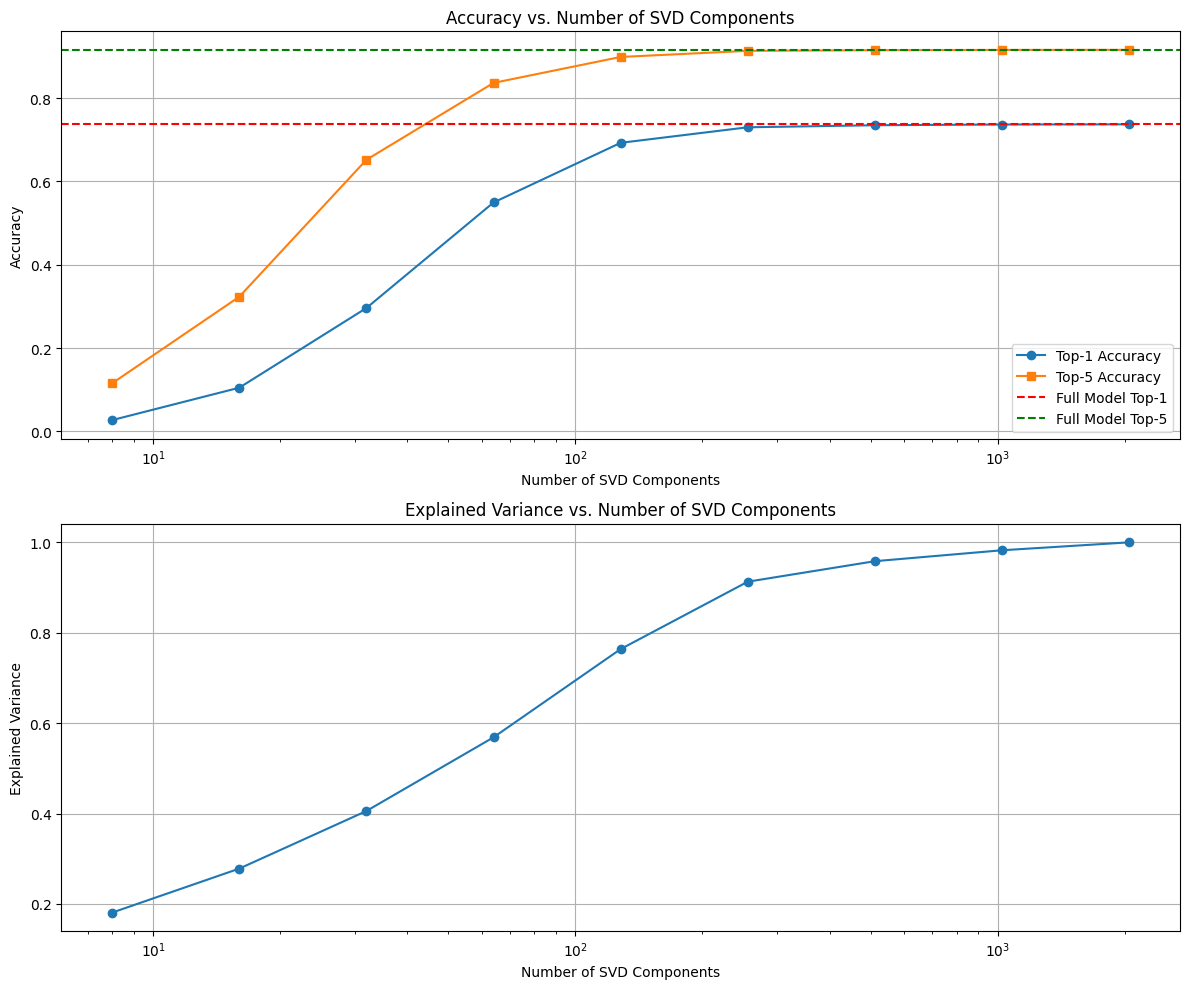

In [51]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_from_disk
from sklearn.decomposition import TruncatedSVD

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define preprocessing transform for ResNet50
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Load the validation dataset
dataset_path = "data/imagenet_1k_resized_256_val"
ds = load_from_disk(dataset_path)
print(f"Loaded dataset with {len(ds)} samples")

# Load pretrained ResNet50
print("Loading pretrained ResNet50...")
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)
resnet50.eval()

# Get the classification layer weights
fc_weight = resnet50.fc.weight.data.cpu().numpy()  # Shape: (1000, 2048)
fc_bias = resnet50.fc.bias.data.cpu().numpy()  # Shape: (1000,)

# Create a feature extractor (remove the final FC layer)
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)

# Create the feature extractor
print("Creating feature extractor...")
feature_extractor = FeatureExtractor(resnet50)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

def evaluate_full_model(model, dataset, batch_size=32, num_samples=None):
    """
    Evaluate the full model on the dataset for top-1 and top-5 accuracy
    """
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)
    
    top1_correct = 0
    top5_correct = 0
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Evaluating full model"):
        end_idx = min(i + batch_size, num_samples)
        batch_indices = range(i, end_idx)
        batch_images = []
        batch_labels = []
        
        # Process each image in the batch
        for idx in batch_indices:
            sample = dataset[idx]
            image = sample['image']
            label = sample['label']
            transformed_image = transform(image)
            
            batch_images.append(transformed_image)
            batch_labels.append(label)
        
        # Forward pass
        batch_tensor = torch.stack(batch_images).to(device)
        labels_tensor = torch.tensor(batch_labels).to(device)
        
        with torch.no_grad():
            outputs = model(batch_tensor)
            
            # Top-1 accuracy
            _, predicted = outputs.max(1)
            top1_correct += (predicted == labels_tensor).sum().item()
            
            # Top-5 accuracy
            _, top5_predictions = outputs.topk(5, dim=1)
            labels_expanded = labels_tensor.view(-1, 1).expand_as(top5_predictions)
            top5_correct += (top5_predictions == labels_expanded).any(dim=1).sum().item()
    
    top1_accuracy = top1_correct / num_samples
    top5_accuracy = top5_correct / num_samples
    
    return top1_accuracy, top5_accuracy

def extract_embeddings(model, dataset, batch_size=32, num_samples=None):
    """
    Extract embeddings (features before the final classification layer)
    """
    if num_samples is None or num_samples > len(dataset):
        num_samples = len(dataset)
    
    all_embeddings = []
    all_labels = []
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Extracting embeddings"):
        end_idx = min(i + batch_size, num_samples)
        batch_indices = range(i, end_idx)
        batch_images = []
        batch_labels = []
        
        # Process each image in the batch
        for idx in batch_indices:
            sample = dataset[idx]
            image = sample['image']
            label = sample['label']
            transformed_image = transform(image)
            
            batch_images.append(transformed_image)
            batch_labels.append(label)
        
        # Extract features
        batch_tensor = torch.stack(batch_images).to(device)
        
        with torch.no_grad():
            embeddings = model(batch_tensor)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.extend(batch_labels)
    
    embeddings_array = np.vstack(all_embeddings)
    labels_array = np.array(all_labels)
    
    print(f"Extracted {embeddings_array.shape[0]} embeddings with shape {embeddings_array.shape}")
    return embeddings_array, labels_array

def evaluate_with_svd(embeddings, labels, fc_weight, fc_bias, n_components):
    """
    Evaluate performance using SVD-reduced embeddings and the original model's weights
    """
    # Apply SVD if needed
    if n_components < embeddings.shape[1]:
        print(f"Applying SVD to reduce from {embeddings.shape[1]} to {n_components} dimensions...")
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd.fit(embeddings)
        
        # Project embeddings to reduced space
        reduced_embeddings = svd.transform(embeddings)
        
        # Project weights to reduced space
        # Original: logits = embeddings @ fc_weight.T + fc_bias
        # Reduced: logits = reduced_embeddings @ (fc_weight @ V.T).T + fc_bias
        # where V is the SVD components matrix (V.T is the projection matrix)
        projection_matrix = svd.components_  # Shape: (n_components, original_dim)
        projected_weights = fc_weight @ projection_matrix.T  # Shape: (1000, n_components)
        
        explained_var = svd.explained_variance_ratio_.sum()
    else:
        # Use full embeddings
        print(f"Using full {embeddings.shape[1]} dimensions (no reduction)...")
        reduced_embeddings = embeddings
        projected_weights = fc_weight
        explained_var = 1.0
    
    # Calculate logits using the projected weights
    print("Computing logits and accuracy...")
    logits = reduced_embeddings @ projected_weights.T + fc_bias
    
    # Calculate top-1 accuracy
    top1_preds = np.argmax(logits, axis=1)
    top1_accuracy = np.mean(top1_preds == labels)
    
    # Calculate top-5 accuracy
    top5_indices = np.argsort(logits, axis=1)[:, -5:]
    top5_correct = 0
    for i, label in enumerate(labels):
        if label in top5_indices[i]:
            top5_correct += 1
    
    top5_accuracy = top5_correct / len(labels)
    
    return top1_accuracy, top5_accuracy, explained_var

# Main evaluation pipeline
print("\nEvaluating full ResNet50 model...")
full_top1, full_top5 = evaluate_full_model(resnet50, ds, batch_size=32)
print(f"Full ResNet50 - Top-1 Accuracy: {full_top1:.4f}, Top-5 Accuracy: {full_top5:.4f}")

# Extract embeddings
print("\nExtracting embeddings from the validation set...")
embeddings, labels = extract_embeddings(feature_extractor, ds, batch_size=32)

# Define the dimensions to evaluate
svd_dims = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]  # 2048 is the full dimension

# Store results
results = []

# Add full model result
results.append({
    'dim': 'Full Model',
    'explained_variance': 1.0,
    'top1_accuracy': full_top1,
    'top5_accuracy': full_top5
})

# Evaluate with different SVD dimensions
for dim in svd_dims:
    print(f"\nEvaluating with {dim} SVD components...")
    
    top1_acc, top5_acc, explained_var = evaluate_with_svd(
        embeddings, 
        labels, 
        fc_weight, 
        fc_bias, 
        n_components=dim
    )
    
    results.append({
        'dim': dim,
        'explained_variance': explained_var,
        'top1_accuracy': top1_acc,
        'top5_accuracy': top5_acc
    })
    
    print(f"SVD {dim} - Explained Variance: {explained_var:.4f}, Top-1 Accuracy: {top1_acc:.4f}, Top-5 Accuracy: {top5_acc:.4f}")

# Display summary of results
print("\nSummary of Results:")
print("------------------")
print(f"{'Dimensions':<12} {'Explained Var':<15} {'Top-1 Acc':<15} {'Top-5 Acc':<15}")
print("-" * 62)
for result in results:
    dim_str = str(result['dim'])
    print(f"{dim_str:<12} {result['explained_variance']:<15.4f} {result['top1_accuracy']:<15.4f} {result['top5_accuracy']:<15.4f}")

# Plot the results
dims = [result['dim'] for result in results if isinstance(result['dim'], int)]
top1_accs = [result['top1_accuracy'] for result in results if isinstance(result['dim'], int)]
top5_accs = [result['top5_accuracy'] for result in results if isinstance(result['dim'], int)]
exp_vars = [result['explained_variance'] for result in results if isinstance(result['dim'], int)]

plt.figure(figsize=(12, 10))

# Plot accuracy vs dimensions
plt.subplot(2, 1, 1)
plt.semilogx(dims, top1_accs, 'o-', label='Top-1 Accuracy')
plt.semilogx(dims, top5_accs, 's-', label='Top-5 Accuracy')
plt.axhline(y=full_top1, color='r', linestyle='--', label='Full Model Top-1')
plt.axhline(y=full_top5, color='g', linestyle='--', label='Full Model Top-5')
plt.xlabel('Number of SVD Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Accuracy vs. Number of SVD Components')

# Plot explained variance vs dimensions
plt.subplot(2, 1, 2)
plt.semilogx(dims, exp_vars, 'o-')
plt.xlabel('Number of SVD Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.title('Explained Variance vs. Number of SVD Components')

plt.tight_layout()
plt.savefig('reports/svd_performance.png')
plt.show()

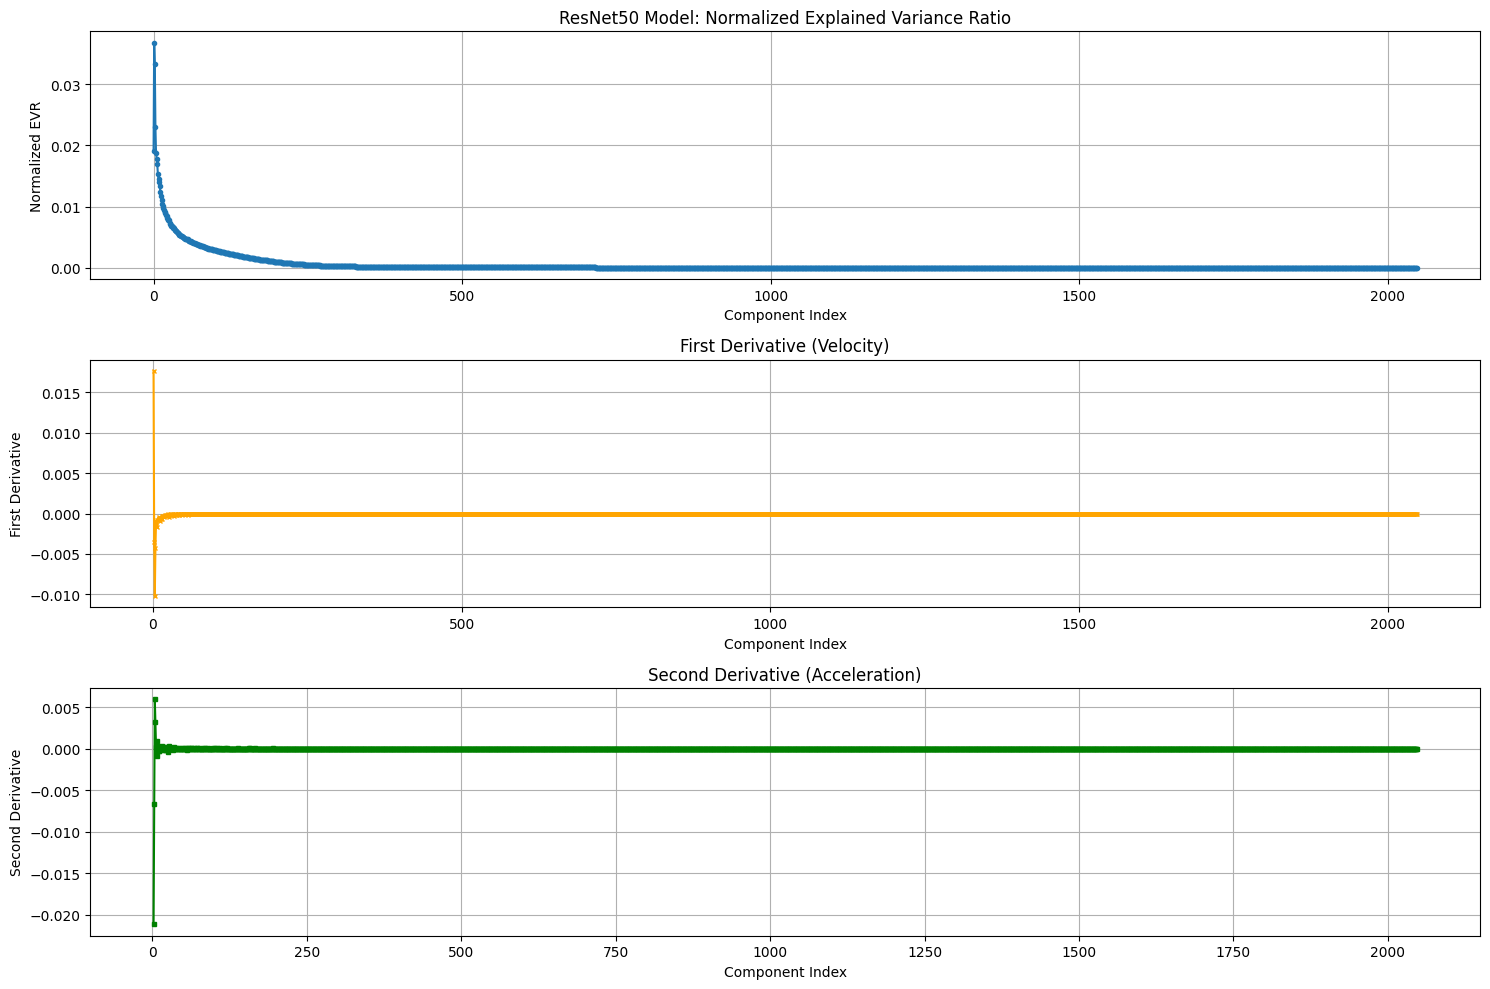

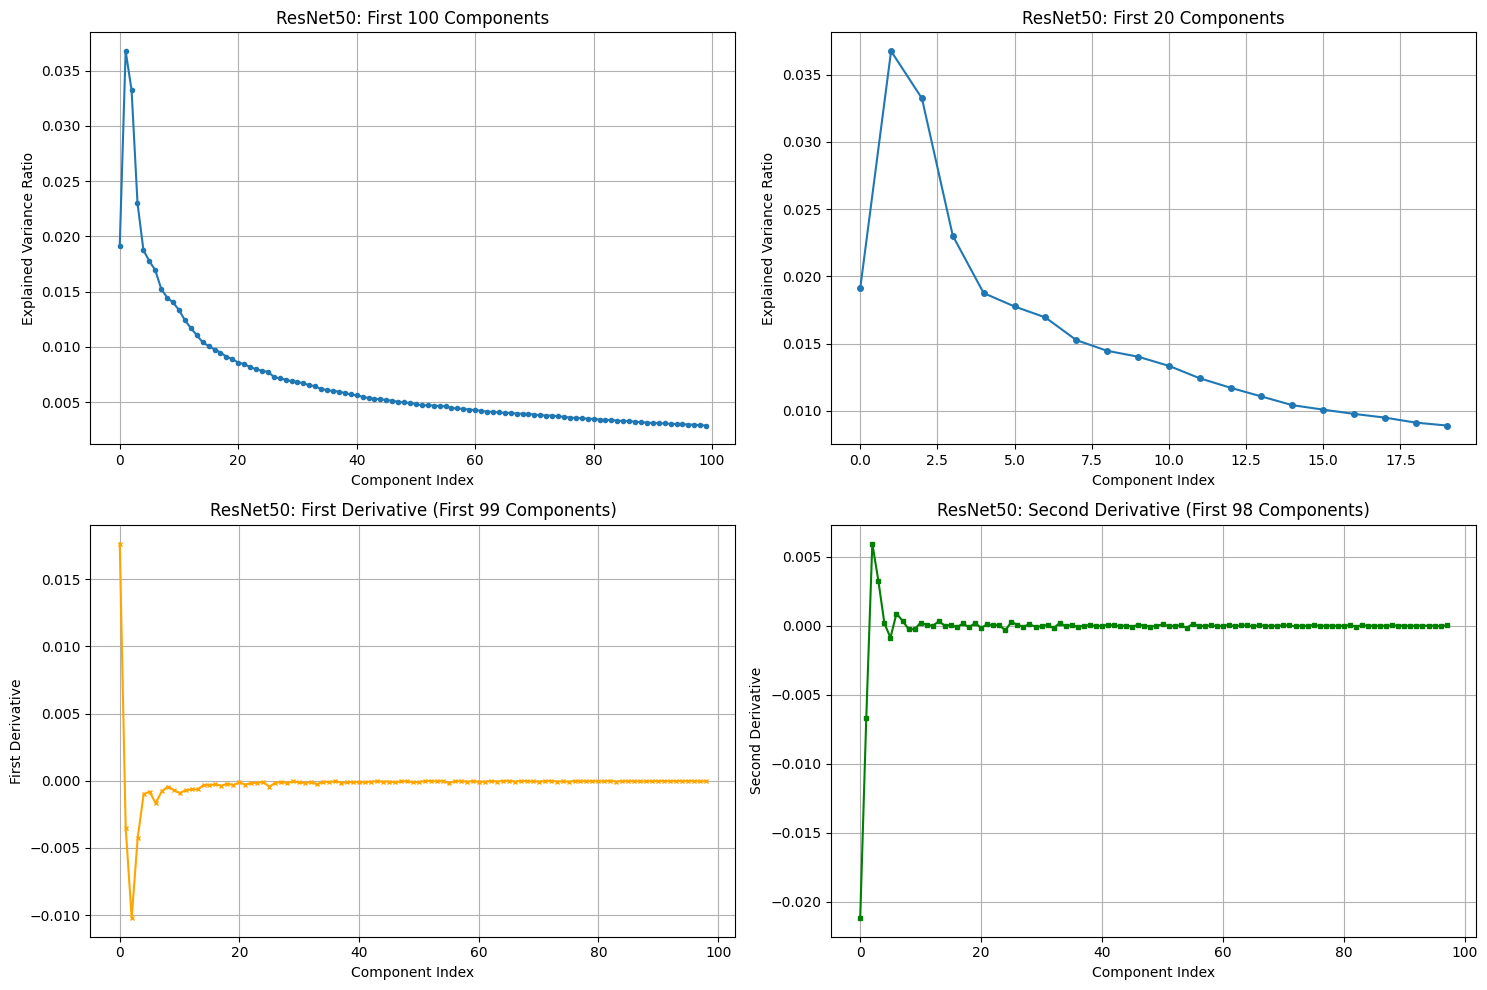

In [52]:
resnet_evr = np.zeros(2048)
svd = TruncatedSVD(n_components=2047, random_state=42)  # Max for TruncatedSVD is n-1
svd.fit(embeddings)
resnet_evr[:2047] = svd.explained_variance_ratio_

# Plot ResNet EVR and derivatives
plot_evr_and_derivatives(resnet_evr, "ResNet50 Model", save_path="reports/resnet_evr_derivatives.png")

# Plot the first few components in more detail
plt.figure(figsize=(15, 10))

# Plot first 100 components
plt.subplot(2, 2, 1)
plt.plot(resnet_evr[:100], marker='o', markersize=3)
plt.title("ResNet50: First 100 Components")
plt.xlabel("Component Index")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)

# Plot first 20 components
plt.subplot(2, 2, 2)
plt.plot(resnet_evr[:20], marker='o', markersize=4)
plt.title("ResNet50: First 20 Components")
plt.xlabel("Component Index")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)

# Plot derivatives for first 100 components
_, v_resnet, a_resnet = compute_normalized_derivatives(resnet_evr)
plt.subplot(2, 2, 3)
plt.plot(v_resnet[:99], marker='x', markersize=3, color='orange')
plt.title("ResNet50: First Derivative (First 99 Components)")
plt.xlabel("Component Index")
plt.ylabel("First Derivative")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(a_resnet[:98], marker='s', markersize=3, color='green')
plt.title("ResNet50: Second Derivative (First 98 Components)")
plt.xlabel("Component Index")
plt.ylabel("Second Derivative")
plt.grid(True)

plt.tight_layout()
plt.savefig("reports/resnet_evr_detailed.png")
plt.show()

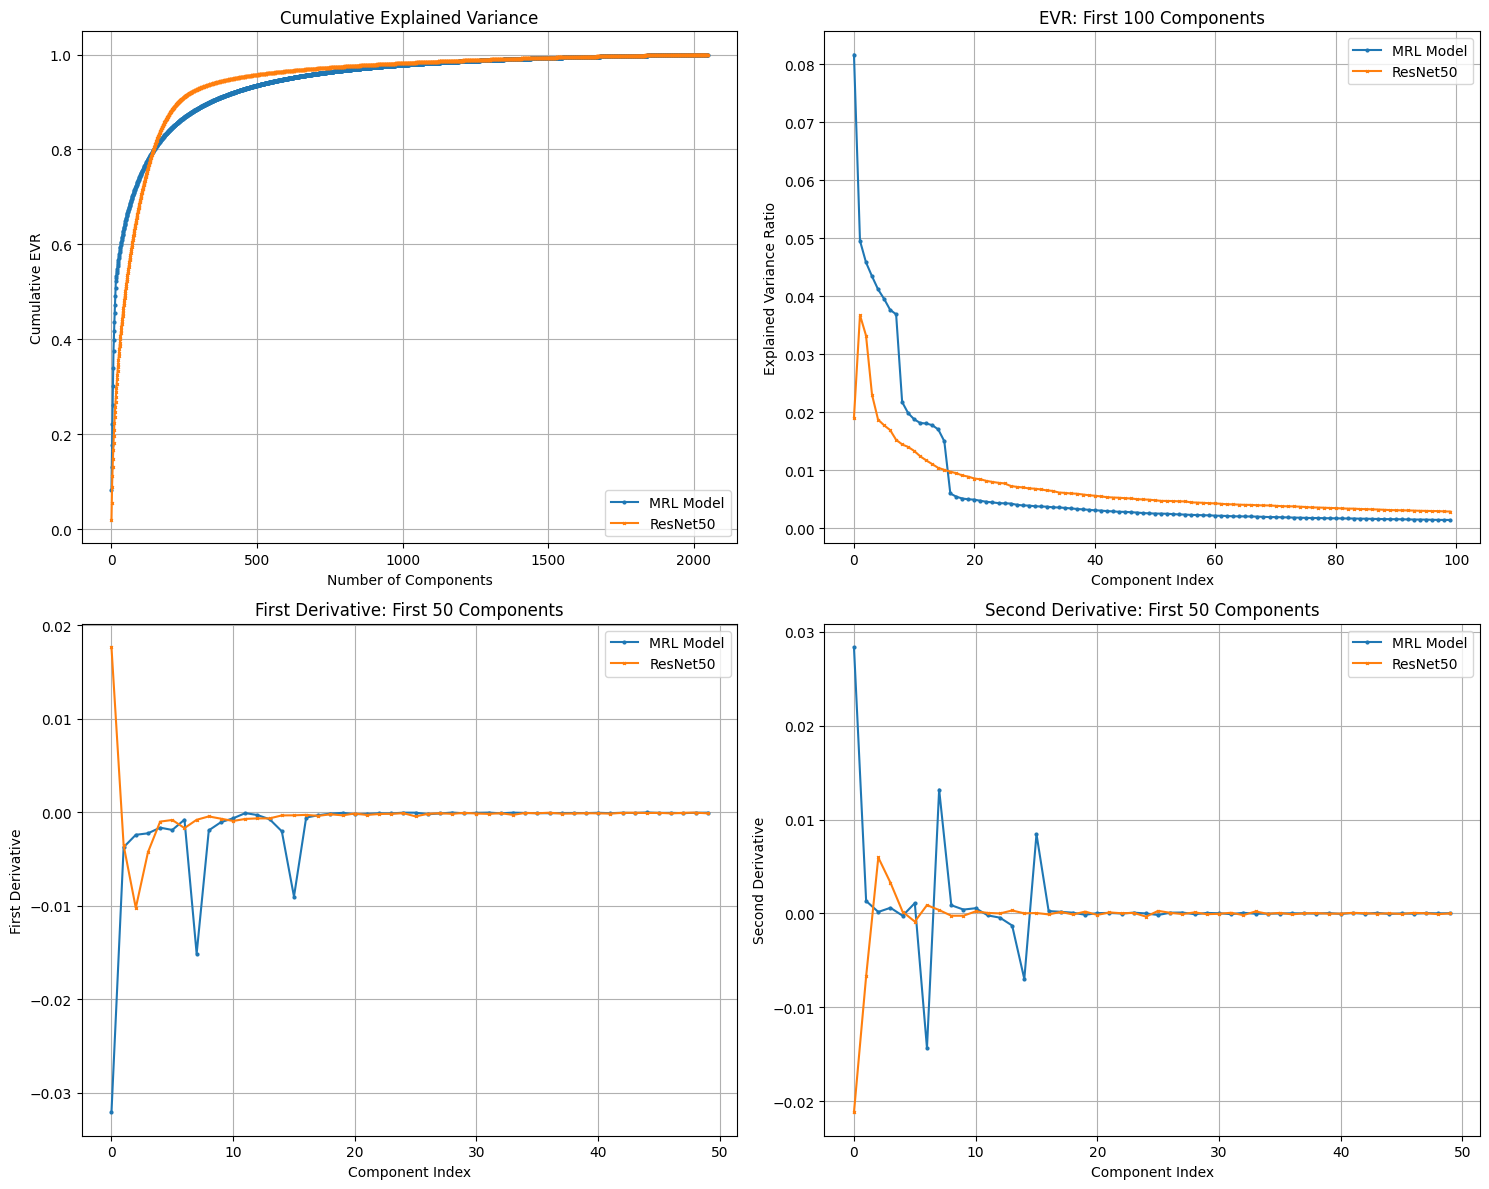

In [53]:
plt.figure(figsize=(15, 12))

# Compare cumulative EVR
plt.subplot(2, 2, 1)
plt.plot(np.cumsum(mrl_evr), label='MRL Model', marker='o', markersize=2)
plt.plot(np.cumsum(resnet_evr), label='ResNet50', marker='x', markersize=2)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative EVR")
plt.legend()
plt.grid(True)

# Compare EVR
plt.subplot(2, 2, 2)
plt.plot(mrl_evr[:100], label='MRL Model', marker='o', markersize=2)
plt.plot(resnet_evr[:100], label='ResNet50', marker='x', markersize=2)
plt.title("EVR: First 100 Components")
plt.xlabel("Component Index")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)

# Compare first derivatives
plt.subplot(2, 2, 3)
plt.plot(v_mrl[:50], label='MRL Model', marker='o', markersize=2)
plt.plot(v_resnet[:50], label='ResNet50', marker='x', markersize=2)
plt.title("First Derivative: First 50 Components")
plt.xlabel("Component Index")
plt.ylabel("First Derivative")
plt.legend()
plt.grid(True)

# Compare second derivatives
plt.subplot(2, 2, 4)
plt.plot(a_mrl[:50], label='MRL Model', marker='o', markersize=2)
plt.plot(a_resnet[:50], label='ResNet50', marker='x', markersize=2)
plt.title("Second Derivative: First 50 Components")
plt.xlabel("Component Index")
plt.ylabel("Second Derivative")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("reports/mrl_vs_resnet_evr_comparison.png")
plt.show()